# Citiy comparison: East vs. West Germany

In this Notebook I would like to explore some very basic differences of living in Germany.
I will do this with a set of four criteria: Education, Food, Leisure and Culture.
Leipzig and Dresden will represent east Germany, whereas Frankfurt and Nürnberg represent west Germany.

In [10]:
import pandas as pd
import numpy as np
import bs4 as bs
import matplotlib.pyplot as plt
from matplotlib import style
import pandas as pd
import pickle
import requests
import pandas_datareader as pdr
from pandas_datareader import data, wb
from pandas.io.json import json_normalize

In [2]:
#Postal Codes of German Cities
dresden = int("01067")
leipzig = int("04103")
frankfurt = 60311
nürnberg = 90402

#Create DataFrame
cities = pd.DataFrame({"City":["Dresden", "Leipzig", "Frankfurt", "Nürnberg"], 
                        "Postal Code":[dresden, leipzig, frankfurt, nürnberg]})
cities

,City,Postal Code
0,Dresden,1067
1,Leipzig,4103
2,Frankfurt,60311
3,Nürnberg,90402


In [4]:
# get coordinates:
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="get_ll")

cities["Latitude"] = 0
cities["Longitude"] = 0

for i in range(0,len(cities.index)):
    location = geolocator.geocode(cities.iloc[i, 0])
    cities.iloc[i, 2] = location.latitude
    cities.iloc[i, 3] = location.longitude

cities

,City,Postal Code,Latitude,Longitude
0,Dresden,1067,51.049329,13.738144
1,Leipzig,4103,51.340632,12.374733
2,Frankfurt,60311,50.110644,8.682092
3,Nürnberg,90402,49.453872,11.077298


In [5]:
# create map of New York using latitude and longitude values
import folium
location = geolocator.geocode("Germany")
latitude = location.latitude
longitude = location.longitude

germany_map = folium.Map(location=[latitude, longitude], zoom_start=6)

# add markers to map
for lat, lng, city in zip(cities['Latitude'], cities['Longitude'], cities['City']):
    label = '{}'.format(city)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(germany_map)  
    
germany_map

In [6]:
#Set up Foursquare

CLIENT_ID = '***' # Foursquare ID
CLIENT_SECRET = '***' # Foursquare Secret
VERSION = '20200301'
LIMIT = 500
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: FFTKQJWIZCWYRECOV1Q3UPQLMJDVGIPUV2QCONRP13EBZQSZ
CLIENT_SECRET:5FGTT3YRX2EEGQH2HTUTFCYGOSXKKYQYKZV523TSKA42UV3O


In [7]:
#Define Specific criteria on which the citys can be compared
culture = ["Museum", "Park", "Theater", "Oper"]
leisure = ["Schwimmbad", "Kino", "Bowling"]
restaurants = ["Italian", "Spanish", "Sushi", "Chinese", "Korean", "Indian","African"]
education = ["Hochschule", "Universität", "University", "Schule", "Kindergarten"]

#Summarize them in one single list for easy iteration
criteria = [culture, leisure, restaurants, education]

In [27]:
#Full List of venues for every City, Criteria and Criteria-Instance
crit_venues = []

#Bool for checking wether its the first iteration
first_entry = True
first_crit = True
first_city = True

#Iterate for cities Data Frame
for index, city in cities.iterrows():
    #Set coordinates for foursquare request
    latitude = city["Latitude"]
    longitude = city["Longitude"]
    
    first_crit = True
    #Only append to list after first iteration, since otherwise the appended list is empty
    if first_city:
        first_city = False
    else:
        #Append education
        crits.append(results)
        #Append full
        crit_venues.append(crits)
    
    #Iterate through Criteria List
    for crit in criteria:
        #reset List on first iteration
        if first_crit: 
            crits = []
            first_crit = False
        else:
            crits.append(results)
            
        first_entry = True
        
        #get venues for every criteria entry
        for entry in crit:
            #reset list on first iteration
            if first_entry:
                results = []
                first_entry = False
                
            url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, entry, LIMIT)

            result = requests.get(url).json()
            results.append(result)

#Append last results (since they didn't get appendet as the for loop stoped)
crits.append(results)
crit_venues.append(crits)

In [28]:
first_venue = True
first_crit = True
first_city = True
venue_df = None
first = True

str_criteria = ["culture", "leisure", "restaurants", "education"]

venue_counter = 0
crit_counter = 0
city_counter = 0

for city in crit_venues:
    
    if first_city:
        first_city = False
    else:
        city_counter += 1
    
    first_crit = True
    
    for crit in crit_venues[city_counter]:
        
        if first_crit:
            first_crit = False
            crit_counter = 0
        else:
            crit_counter+=1
            
        first_venue = True
        
        
        for venue in crit_venues[city_counter][crit_counter]:
            
            if first_venue:
                venue_counter = 0
                first_venue = False
                step = json_normalize(venue["response"]["venues"])
                step["Venue"] = criteria[crit_counter][venue_counter]
                step["Criteria"] = str_criteria[crit_counter]
                step["City"] = cities.loc[city_counter, "City"]
                if first:
                    venue_df = step.copy()
                    first = False
                else:
                    venue_df = venue_df.append(step)
            else:    
                step = json_normalize(venue["response"]["venues"])
                step["Venue"] = criteria[crit_counter][venue_counter]
                step["Criteria"] = str_criteria[crit_counter]
                step["City"] = cities.loc[city_counter, "City"]
                venue_df = venue_df.append(step)
                
            venue_counter += 1

In [29]:
final_df = venue_df[["City","Criteria", "Venue", "name", "location.lat", "location.lng","location.postalCode",  "location.city"]]
final_df.rename(columns = {"location.lat":"Latitude"}, inplace = True)
final_df.rename(columns = {"location.lng":"Longitude"}, inplace = True)
final_df.rename(columns = {"location.postalCode":"Postcode"}, inplace = True)
final_df.rename(columns = {"name":"Name"}, inplace = True)

final_df.head()

,City,Criteria,Venue,Name,Latitude,Longitude,Postcode,location.city
0,Dresden,culture,Museum,Deutsches Hygiene-Museum,51.044281,13.746665,01069,Dresden
1,Dresden,culture,Museum,Museum Wentao,51.044727,13.739973,01069,Dresden
2,Dresden,culture,Museum,H Deutsches Hygiene-Museum,51.047682,13.749675,01069,Dresden
3,Dresden,culture,Museum,Erich Kästner Museum,51.063724,13.745667,01097,Dresden
4,Dresden,culture,Museum,Militärhistorisches Museum der Bundeswehr (MHM),51.077802,13.759547,01099,Dresden


In [30]:
final_df.shape

(1841, 8)

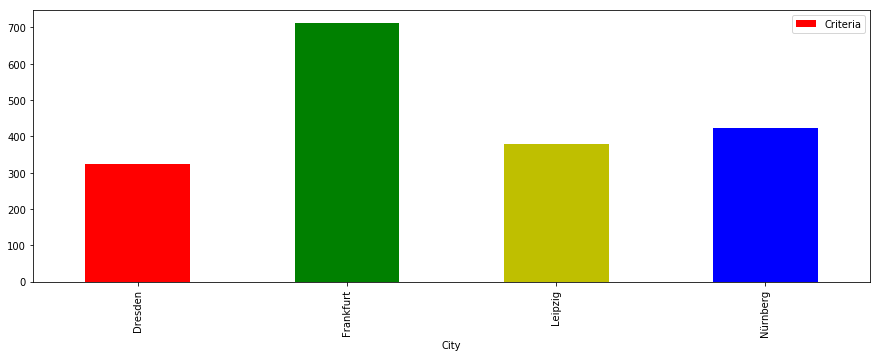

In [31]:
final_df.groupby("City")["Criteria"].aggregate("count").plot(kind = "bar", figsize = (15, 5), color = ["r", "g", "y", "b"], legend=True)
plt.show()

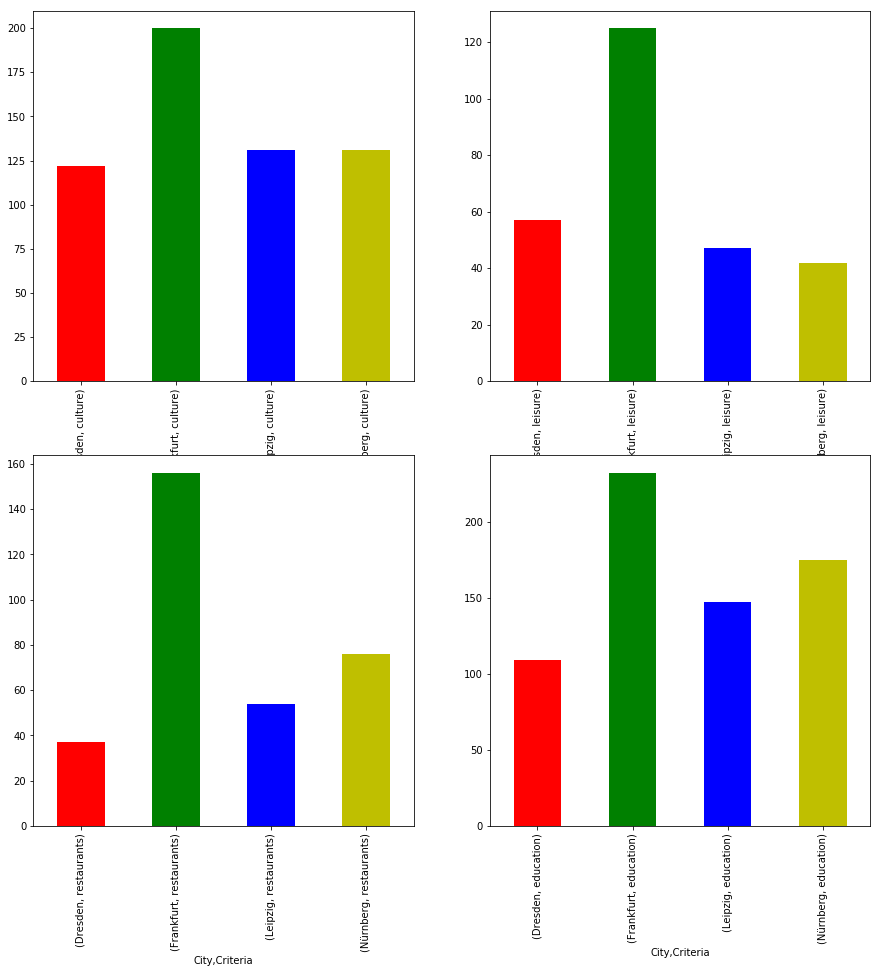

In [21]:
fig = plt.figure(figsize = (15,15))

ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

final_df[final_df["Criteria"] == "culture"].groupby("City")["Criteria"].value_counts().plot(kind = "bar", color = ["r", "g", "b","y"], ax = ax1)
final_df[final_df["Criteria"] == "leisure"].groupby("City")["Criteria"].value_counts().plot(kind = "bar",color = ["r", "g", "b", "y"], ax = ax2)
final_df[final_df["Criteria"] == "restaurants"].groupby("City")["Criteria"].value_counts().plot(kind = "bar",color = ["r", "g", "b", "y"], ax = ax3)
final_df[final_df["Criteria"] == "education"].groupby("City")["Criteria"].value_counts().plot(kind = "bar",color = ["r", "g", "b", "y"], ax = ax4)

plt.show()

### Explore why Frankfurt has so many more venues than the other cities:

In [22]:
location = geolocator.geocode("Frankfurt, DE")
latitude = location.latitude
longitude = location.longitude

frankfurt_map = folium.Map(location=[latitude, longitude], zoom_start=10)

frankfurt_culture = final_df[(final_df["City"] == "Frankfurt") & (final_df["Criteria"] == "culture")]

# add markers to map
for lat, lng, venue in zip(frankfurt_culture['Latitude'], frankfurt_culture['Longitude'], frankfurt_culture['Name']):
    label = '{}'.format(venue)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(frankfurt_map)  
    
frankfurt_map

##### It looks like foursquare went a bit overboard with the results. Wiesbaden is defnetly not Frankfurt.
##### Lets check all the citiy locations: 

In [23]:
final_df["location.city"].unique()

array(['Dresden', 'Radebeul', 'Coswig', 'Rabenau', 'Pirna', 'Kamenz', nan,
       'Frauenstein', 'Bautzen', 'Hohnstein', 'Oedersn',
       'Neuhausen/Erzgeb.', 'Großkoschen', 'Meißen', 'Freiberg',
       'Moritzburg', 'Riesa', 'Ruhland', 'Mügeln', 'Berlin', 'Königstein',
       'Mikulov', 'Děčín', 'Döbeln', 'Meziboří', 'Ústí nad Labem',
       'Schwarzheide', 'Bühlau', 'Bischofswerda', 'Ottendorf-Okrilla',
       'Litvínov', 'Dresden-Niederpoyritz', 'Kreischa', 'Schwepnitz',
       'Bad Schandau', 'Nossen', 'Oederan', 'Bannewitz', 'Stolpen',
       'Dorfchemnitz', 'Senftenberg', 'Leipzig', 'Lützen', 'Halle',
       'Machern', 'Altenburg', 'Merseburg', 'Zschadraß', 'Zeitz',
       'Markkleeberg', 'Großpösna', 'Wurzen', 'Bad Lauchstädt',
       'Waldenburg', 'Taucha', 'Leuna', 'Merseburg (Saale)', 'Weißenfels',
       'Delitzsch', 'Beucha', 'Naunhof', 'Grimma', 'Zeitz-Grana',
       'Geithain', 'Meuselwitz', 'Günthersdorf', 'Belgershain',
       'Borsdorf', 'Jesewitz', 'Gröben', 'Nöbdeni

That is way to many. 
So lets try just to take the venues directly located in the cities

### Drop every Location that is not directly one of the cities of interest

In [24]:
final_df = final_df[(final_df["location.city"] == "Nürnberg") | (final_df["location.city"] == "Frankfurt am Main")
        | (final_df["location.city"] == "Dresden") | (final_df["location.city"] == "Leipzig")]

In [25]:
#Lets check Frankfurt again
location = geolocator.geocode("Frankfurt, DE")
latitude = location.latitude
longitude = location.longitude

frankfurt_map = folium.Map(location=[latitude, longitude], zoom_start=12)

frankfurt_culture = final_df[(final_df["City"] == "Frankfurt") & (final_df["Criteria"] == "culture")]

# add markers to map
for lat, lng, venue in zip(frankfurt_culture['Latitude'], frankfurt_culture['Longitude'], frankfurt_culture['Name']):
    label = '{}'.format(venue)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(frankfurt_map)  
    
frankfurt_map

That looks much better.
Now plot them again and then we can try to summarize the findings

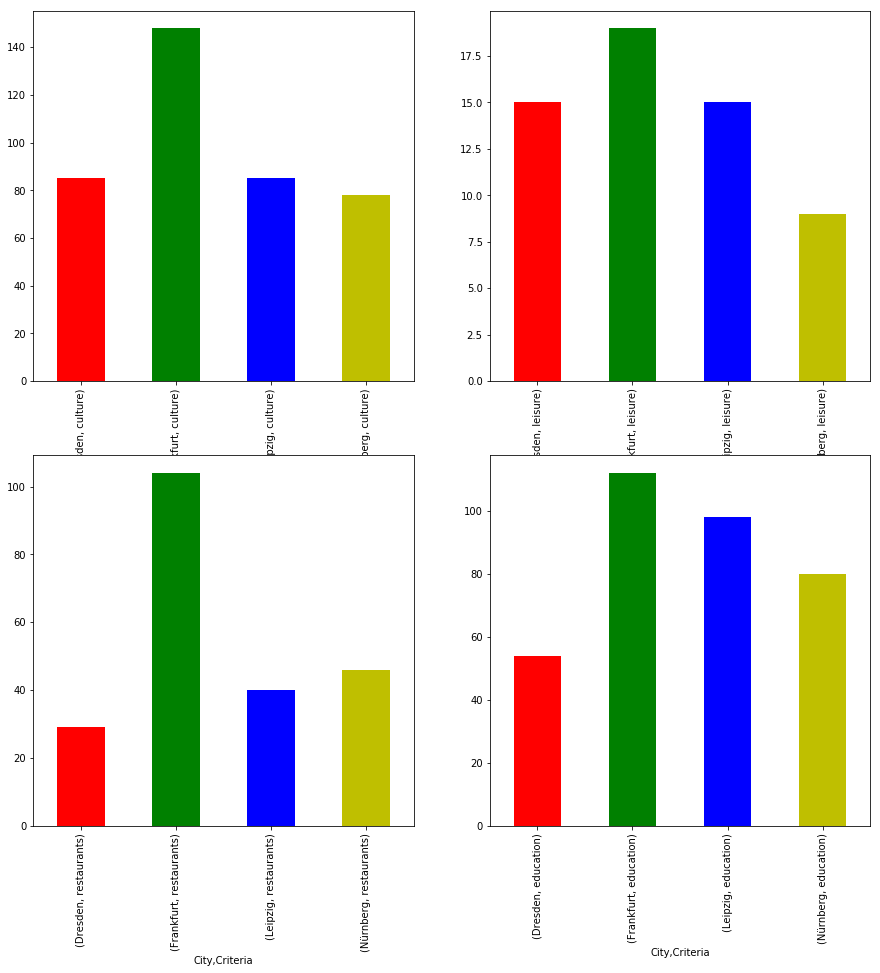

In [26]:
fig = plt.figure(figsize = (15,15))

ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

final_df[final_df["Criteria"] == "culture"].groupby("City")["Criteria"].value_counts().plot(kind = "bar", color = ["r", "g", "b","y"], ax = ax1)
final_df[final_df["Criteria"] == "leisure"].groupby("City")["Criteria"].value_counts().plot(kind = "bar",color = ["r", "g", "b", "y"], ax = ax2)
final_df[final_df["Criteria"] == "restaurants"].groupby("City")["Criteria"].value_counts().plot(kind = "bar",color = ["r", "g", "b", "y"], ax = ax3)
final_df[final_df["Criteria"] == "education"].groupby("City")["Criteria"].value_counts().plot(kind = "bar",color = ["r", "g", "b", "y"], ax = ax4)

plt.show()

# Observation:

Nürnberg, Dresden and Leipzig don't seem to be too far apart in regards to the four categories.
Frankfurt on the other hand is an outlier. Espacially in Culture and Restaurants.
I am quite surprised that Frankfurt seems to have so much more Restaurants than the other three cities.
The explanation is to be found in the criteria I picked for the restaurants: 
            "Italian", "Spanish", "Sushi", "Chinese", "Korean", "Indian","African"
These are all foreign cuisines. And since Frankfurt is known to be a particularily multi cultural city it doesn't surprise, that many restaurants of foreign cuisine are to be found there.
Wheras Nürnberg Dresden and Leipzig seem to have less of a cultural variety.

# Restrictions:

In this comparison I chose 4 cities with roughly the same size. It is to be noted though, that that Franfurt has roughly 200k more inhabitants.
A more precise way to look at the data would possibly be calculating the criteria in proportion to population count, or square kilometer.
Also the availability of Jobs, the payment and the living cost contribute a hughe part to the living quality in one place. This hasn't been taken into account in this exploration.

# Conclusion:

It seems that Frankfurt has defnetly a lot more variety going than the other three cities.
Between Nürnberg, Dresden and Leipzig doesn't seem to be a big difference though. 
We could conclude from this, that living quality in the cities of east germany matches this of west german cities.
That is for the big cities. I don't think one could draw reliable conclusions from this for the whole east / west german perspective.
To do this one had to take into account the population density in the areas as well.
Nevertheless it was interesting to see in how the cities compare to each other.